In [ ]:
# This code is to train a model to detect the abnormality 
# in the hand xray.

In [4]:
import os
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation,Dropout
from keras import regularizers
from keras.optimizers import Adam, Adadelta
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
train_path = 'XR_HAND/train'
valid_path = 'XR_HAND/valid'
test_path = 'XR_HAND/test'

In [6]:
# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches)
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 5413 images belonging to 2 classes.
Found 590 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [7]:
# Confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
#Set the model to be = MobileNet with trained weights transfered.
mobile = keras.applications.mobilenet.MobileNet()

In [49]:
# Modify the structure by removing the last 5 layers 
# and then adding and two dense layers with relu activation
# dropout and one dense layer without dropout 
# and output layer with 7 neurons and softmax activation
x = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)
x = model.layers[-2].output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)

predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

In [51]:
# verify changes
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [44]:
# This cell and the one below is to control which 
# layers to be freezed and which to be trained
for layer in model.layers[:]:
    layer.trainable = True

In [45]:
for layer in model.layers[:-2]:
    layer.trainable = False

In [46]:
# compile the model
model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# start training
model.fit_generator(train_batches, steps_per_epoch=163, 
                    validation_data=valid_batches, validation_steps=590, epochs=10, verbose=2)


Epoch 1/10
 - 19s - loss: 0.6102 - acc: 0.7153 - val_loss: 0.5917 - val_acc: 0.7156
Epoch 2/10
 - 18s - loss: 0.5779 - acc: 0.7374 - val_loss: 0.6006 - val_acc: 0.7178
Epoch 3/10
 - 17s - loss: 0.5684 - acc: 0.7387 - val_loss: 0.5986 - val_acc: 0.6997
Epoch 4/10
 - 18s - loss: 0.5655 - acc: 0.7397 - val_loss: 0.5931 - val_acc: 0.7154
Epoch 5/10
 - 17s - loss: 0.5687 - acc: 0.7405 - val_loss: 0.6150 - val_acc: 0.7005
Epoch 6/10
 - 18s - loss: 0.5716 - acc: 0.7405 - val_loss: 0.5962 - val_acc: 0.7019
Epoch 7/10
 - 18s - loss: 0.5693 - acc: 0.7374 - val_loss: 0.5930 - val_acc: 0.7212
Epoch 8/10
 - 17s - loss: 0.5733 - acc: 0.7405 - val_loss: 0.6115 - val_acc: 0.6795
Epoch 9/10
 - 18s - loss: 0.5648 - acc: 0.7393 - val_loss: 0.5916 - val_acc: 0.7144
Epoch 10/10
 - 17s - loss: 0.5560 - acc: 0.7464 - val_loss: 0.5913 - val_acc: 0.7139


In [58]:
# Get the labels
test_labels = test_batches.classes
# Rest the cursor to the start of the test set befor testing
test_batches.reset()

In [59]:
# Test the model on the test set
predictions = model.predict_generator(test_batches, steps=46, verbose=1)


46/46 [==============================] - 2s 37ms/step


In [60]:
# Prepare the confusion matrix
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [61]:
# check the labels with thier indices
test_batches.class_indices

{'negative': 0, 'positive': 1}

Confusion matrix, without normalization
[[224  47]
 [ 87 102]]


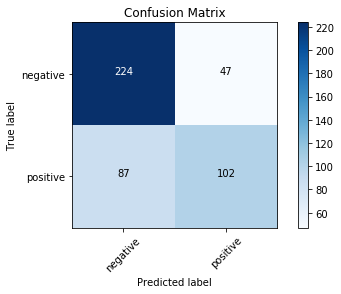

In [62]:
# show the confusion matrix
cm_plot_labels = ['negative','positive']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [63]:
# The overall accuracy of the model
print('Accuracy= ',(cm[0][0]+cm[1][1])*100/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0]),' %')

Accuracy=  70.8695652173913  %


In [64]:
# Prepare the images for (TEST ON STUDY LEVEL)
def prepare_image(file):
    img_path = ''
    img = image.load_img(file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [65]:
# Test the model on the study level:
# 1. all the images in one study are gettting predicted indivisually
# 2. the arithmatic mean of all the images in one study is taken to
#    produce the prediction on the study level

path='MURA-v1.1/valid/XR_HAND/'
img_count=0
img_pos=0
img_neg=0
img_fpos=0
img_fneg=0
true_pos=0
true_neg=0
false_pos=0
false_neg=0
false_pos_lst=[]
false_neg_lst=[]
templst=[]

for patient in os.listdir(path):
    for study in os.listdir(path+patient):
        total_pred=0
        for img in os.listdir(path+patient+'/'+study):
            img_count +=1
            print(path+patient+'/'+study+'/'+img)
            preprocessed_image = prepare_image(path+patient+'/'+study+'/'+img)
            predictions = model.predict(preprocessed_image)
            if predictions[0][1]>0.5 and study.split('_')[1] == 'positive':
                img_pos += 1
            elif predictions[0][1]<=0.5 and study.split('_')[1] == 'negative':
                img_neg += 1
            elif predictions[0][1]>0.5 and study.split('_')[1] != 'positive':
                img_fpos += 1
            else:
                img_fneg += 1
        
            total_pred += predictions[0][1]
        avg_pred = total_pred/len(os.listdir(path+patient+'/'+study))
        if avg_pred <= 0.5:
            abnorm_pred='negative'
        else:
            abnorm_pred='positive'
            
        if abnorm_pred == study.split('_')[1] == 'positive':
            true_pos +=1
        elif abnorm_pred == study.split('_')[1] == 'negative':
            true_neg +=1
        elif abnorm_pred != study.split('_')[1] == 'negative':
            false_pos +=1
            false_pos_lst.append(patient+'/'+study)
        else:
            false_neg +=1
            false_neg_lst.append(patient+'/'+study)


  
  

MURA-v1.1/valid/XR_HAND/patient11581/study1_negative/image2.png
MURA-v1.1/valid/XR_HAND/patient11581/study1_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11577/study1_negative/image2.png
MURA-v1.1/valid/XR_HAND/patient11577/study1_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11573/study1_negative/image2.png
MURA-v1.1/valid/XR_HAND/patient11573/study1_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11240/study1_negative/image3.png
MURA-v1.1/valid/XR_HAND/patient11240/study1_negative/image2.png
MURA-v1.1/valid/XR_HAND/patient11240/study1_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11503/study1_positive/image3.png
MURA-v1.1/valid/XR_HAND/patient11503/study1_positive/image2.png
MURA-v1.1/valid/XR_HAND/patient11503/study1_positive/image1.png
MURA-v1.1/valid/XR_HAND/patient11406/study1_negative/image2.png
MURA-v1.1/valid/XR_HAND/patient11406/study1_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11571/study1_negative/image3.png
MURA-v1.1/valid/XR_HAND/patient11571/stu

MURA-v1.1/valid/XR_HAND/patient11255/study1_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11255/study2_negative/image2.png
MURA-v1.1/valid/XR_HAND/patient11255/study2_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11521/study1_positive/image3.png
MURA-v1.1/valid/XR_HAND/patient11521/study1_positive/image2.png
MURA-v1.1/valid/XR_HAND/patient11521/study1_positive/image1.png
MURA-v1.1/valid/XR_HAND/patient11586/study1_negative/image3.png
MURA-v1.1/valid/XR_HAND/patient11586/study1_negative/image2.png
MURA-v1.1/valid/XR_HAND/patient11586/study1_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11569/study1_negative/image3.png
MURA-v1.1/valid/XR_HAND/patient11569/study1_negative/image2.png
MURA-v1.1/valid/XR_HAND/patient11569/study1_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11529/study1_positive/image3.png
MURA-v1.1/valid/XR_HAND/patient11529/study1_positive/image2.png
MURA-v1.1/valid/XR_HAND/patient11529/study1_positive/image1.png
MURA-v1.1/valid/XR_HAND/patient11238/stu

MURA-v1.1/valid/XR_HAND/patient11598/study1_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11518/study1_positive/image2.png
MURA-v1.1/valid/XR_HAND/patient11518/study1_positive/image1.png
MURA-v1.1/valid/XR_HAND/patient11498/study1_positive/image3.png
MURA-v1.1/valid/XR_HAND/patient11498/study1_positive/image2.png
MURA-v1.1/valid/XR_HAND/patient11498/study1_positive/image1.png
MURA-v1.1/valid/XR_HAND/patient11560/study1_negative/image3.png
MURA-v1.1/valid/XR_HAND/patient11560/study1_negative/image2.png
MURA-v1.1/valid/XR_HAND/patient11560/study1_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11408/study1_negative/image3.png
MURA-v1.1/valid/XR_HAND/patient11408/study1_negative/image2.png
MURA-v1.1/valid/XR_HAND/patient11408/study1_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11596/study1_negative/image2.png
MURA-v1.1/valid/XR_HAND/patient11596/study1_negative/image1.png
MURA-v1.1/valid/XR_HAND/patient11524/study2_negative/image3.png
MURA-v1.1/valid/XR_HAND/patient11524/stu

In [66]:
## Testing on the original MURA Dataset 

print('Total number of images = ',img_count)
print('True Positive = ',img_pos)
print('True Nigative= ',img_neg)
print('False Positive = ',img_fpos)
print('False Nigative= ',img_fneg)
print('Accuracy on IMAGE level =', 100*(img_pos+img_neg)/(img_pos+img_neg+img_fpos+img_fneg))
print('')
print('True Positive = ',true_pos)
print('True Nigative= ',true_neg)
print('False Positive = ',false_pos)
print('False Nigative= ',false_neg)
print('Accuracy on STUDY level =', 100*(true_neg+true_pos)/(true_neg+true_pos+false_neg+false_pos))

Total number of images =  460
True Positive =  102
True Nigative=  224
False Positive =  47
False Nigative=  87
Accuracy on IMAGE level = 70.8695652173913

True Positive =  37
True Nigative=  93
False Positive =  8
False Nigative=  29
Accuracy on STUDY level = 77.8443113772455


In [26]:
#### SAVE MODEL ####

model.save_weights("models/MNXR_HAND.h5")

#Save the model architecture
with open('models/architecture_XR_HAND.json', 'w') as f:
    f.write(model.to_json())